In [1]:
!pip install anvil-uplink

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45228 sha256=599aeb45feb9793328e9e4dd08a4b2c9f261f28a071404cd649ad8eec70e17fb
  Stored in directory: /root/.cache/pip/wheels/2e/7c/ad/d9c746276bf024d44296340869fcb169f1e5d80fb147351a57
Successfully built ws4py


In [2]:
# Importing libraries

from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score
from sklearn import metrics
from sklearn import tree
from google.colab import files

In [3]:
from google.colab import files
uploaded=files.upload()


Saving Crop_recommendation.csv to Crop_recommendation.csv


In [4]:
import anvil.server

In [5]:
anvil.server.connect("server_67Y5A32RLH642QUDXKVJEKSA-L44IM6MJPPREVV6R")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default Environment" as SERVER


In [6]:
df = pd.read_csv('Crop_recommendation.csv')

In [7]:
df.head()

,temperature,humidity,ph,water availability,season,label
0,20.879744,82.002744,6.502985,202.935536,rainy,rice
1,21.770462,80.319644,7.038096,226.655537,rainy,rice
2,23.004459,82.320763,7.840207,263.964248,rainy,rice
3,26.491096,80.158363,6.980401,242.864034,rainy,rice
4,20.130175,81.604873,7.628473,262.717340,rainy,rice


In [8]:
df.isnull().sum()

temperature           0
humidity              0
ph                    0
water availability    0
season                0
label                 0
dtype: int64

<ipython-input-9-8c3f98fdac28>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='water availability', y='season', inner='box', palette='Dark2')


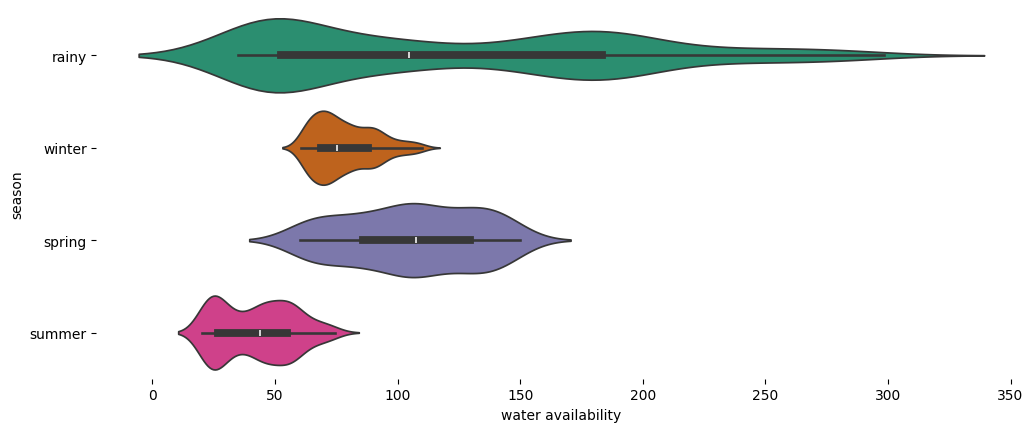

In [9]:
# @title season vs water availability

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['season'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='water availability', y='season', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

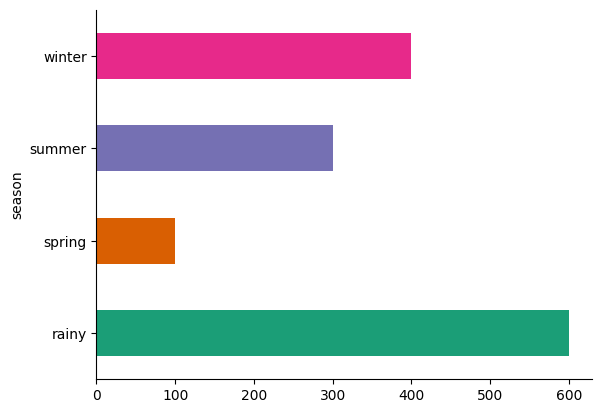

In [10]:
# @title season

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('season').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [11]:
df['season'].value_counts()

season
rainy     600
winter    400
summer    300
spring    100
Name: count, dtype: int64

In [12]:
df.tail()

,temperature,humidity,ph,water availability,season,label
1395,23.874845,86.792613,6.718725,177.514731,rainy,jute
1396,23.928879,88.071123,6.880205,154.660874,rainy,jute
1397,24.814412,81.686889,6.861069,190.788639,rainy,jute
1398,24.447439,82.286484,6.769346,190.968489,rainy,jute
1399,26.574217,73.819949,7.261581,159.322307,rainy,jute


In [13]:
df.shape

(1400, 6)

In [14]:
df['label'].unique()

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'watermelon',
       'muskmelon', 'cotton', 'jute'], dtype=object)

In [15]:
df['label'].value_counts()

label
maize          200
rice           100
chickpea       100
kidneybeans    100
pigeonpeas     100
mothbeans      100
mungbean       100
blackgram      100
lentil         100
watermelon     100
muskmelon      100
cotton         100
jute           100
Name: count, dtype: int64

In [16]:
df.columns

Index(['temperature', 'humidity', 'ph', 'water availability', 'season',
       'label'],
      dtype='object')

In [17]:
season_mapping = {"rainy": 1, "winter": 2, "summer": 3, "spring": 4}

In [18]:
converted_season_column = []
for season in df['season']:
    if season in season_mapping:
        converted_season_column.append(season_mapping[season])
    else:
        print(f"Unknown season: {season}")


In [19]:
df['csc'] = converted_season_column

In [20]:
df.columns

Index(['temperature', 'humidity', 'ph', 'water availability', 'season',
       'label', 'csc'],
      dtype='object')

In [21]:
df.head()

,temperature,humidity,ph,water availability,season,label,csc
0,20.879744,82.002744,6.502985,202.935536,rainy,rice,1
1,21.770462,80.319644,7.038096,226.655537,rainy,rice,1
2,23.004459,82.320763,7.840207,263.964248,rainy,rice,1
3,26.491096,80.158363,6.980401,242.864034,rainy,rice,1
4,20.130175,81.604873,7.628473,262.717340,rainy,rice,1


In [22]:
del df['season']

In [23]:
df1 = df[['temperature','humidity','ph','water availability'	,'csc']]

<Axes: >

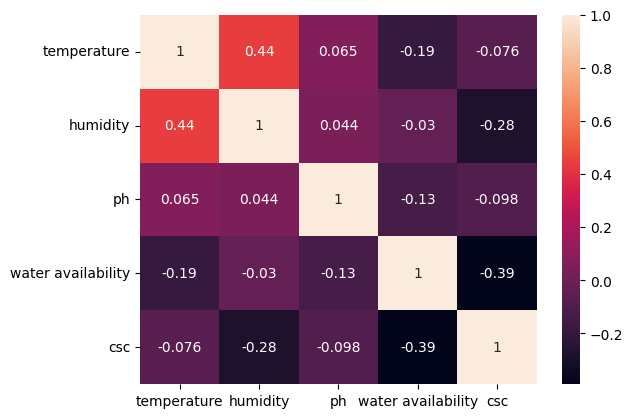

In [24]:
plt.rcParams.update({'font.size': 10})
sns.heatmap(df1.corr(),annot=True)

In [27]:
features1 = df[['temperature', 'humidity', 'ph', 'water availability', 'csc']]
target1 = df['label']

In [28]:
# Initialzing empty lists to append all model's name and corresponding name
acc = []
precision = []
recall = []
f1score = []
model = []

In [29]:
# Splitting into train and test data into 80:20 split

from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(features1,target1,test_size = 0.2,random_state =2)

In [30]:
from imblearn.over_sampling import SMOTE
from collections import Counter

counter = Counter(Ytrain)
print('Before',counter)
smt = SMOTE()
#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_sm, y_train_sm = smt.fit_resample(Xtrain, Ytrain)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({'maize': 166, 'blackgram': 86, 'watermelon': 85, 'rice': 83, 'cotton': 81, 'mungbean': 80, 'mothbeans': 80, 'chickpea': 80, 'kidneybeans': 79, 'muskmelon': 78, 'pigeonpeas': 77, 'jute': 76, 'lentil': 69})
After Counter({'maize': 166, 'cotton': 166, 'lentil': 166, 'rice': 166, 'pigeonpeas': 166, 'mungbean': 166, 'mothbeans': 166, 'watermelon': 166, 'blackgram': 166, 'kidneybeans': 166, 'muskmelon': 166, 'chickpea': 166, 'jute': 166})


In [31]:
from sklearn.tree import DecisionTreeClassifier

DecisionTree = DecisionTreeClassifier(criterion="entropy",random_state=2,max_depth=5)

DecisionTree.fit(Xtrain,Ytrain)

predicted_values = DecisionTree.predict(Xtest)
x = metrics.accuracy_score(Ytest, predicted_values)
acc.append(x)
model.append('Decision Tree')
print("DecisionTrees's Accuracy is: ", x*100)

print(classification_report(Ytest,predicted_values))

report11 = classification_report(Ytest,predicted_values)

DecisionTrees's Accuracy is:  93.92857142857143
              precision    recall  f1-score   support

   blackgram       0.56      1.00      0.72        14
    chickpea       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        19
        jute       0.86      1.00      0.92        24
 kidneybeans       1.00      1.00      1.00        21
      lentil       1.00      1.00      1.00        31
       maize       0.92      0.68      0.78        34
   mothbeans       1.00      1.00      1.00        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        22
  pigeonpeas       1.00      0.91      0.95        23
        rice       1.00      0.76      0.87        17
  watermelon       1.00      1.00      1.00        15

    accuracy                           0.94       280
   macro avg       0.95      0.95      0.94       280
weighted avg       0.96      0.94      0.94       280



In [32]:
sample_data = [[20.87974371,82.00274423,6.502985292,202.9355362,1]]
predicted_crop = DecisionTree.predict(sample_data)

# Print the predicted crop
print("Predicted Crop:", predicted_crop)


Predicted Crop: ['rice']


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [33]:
df['label'].unique()

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'watermelon',
       'muskmelon', 'cotton', 'jute'], dtype=object)

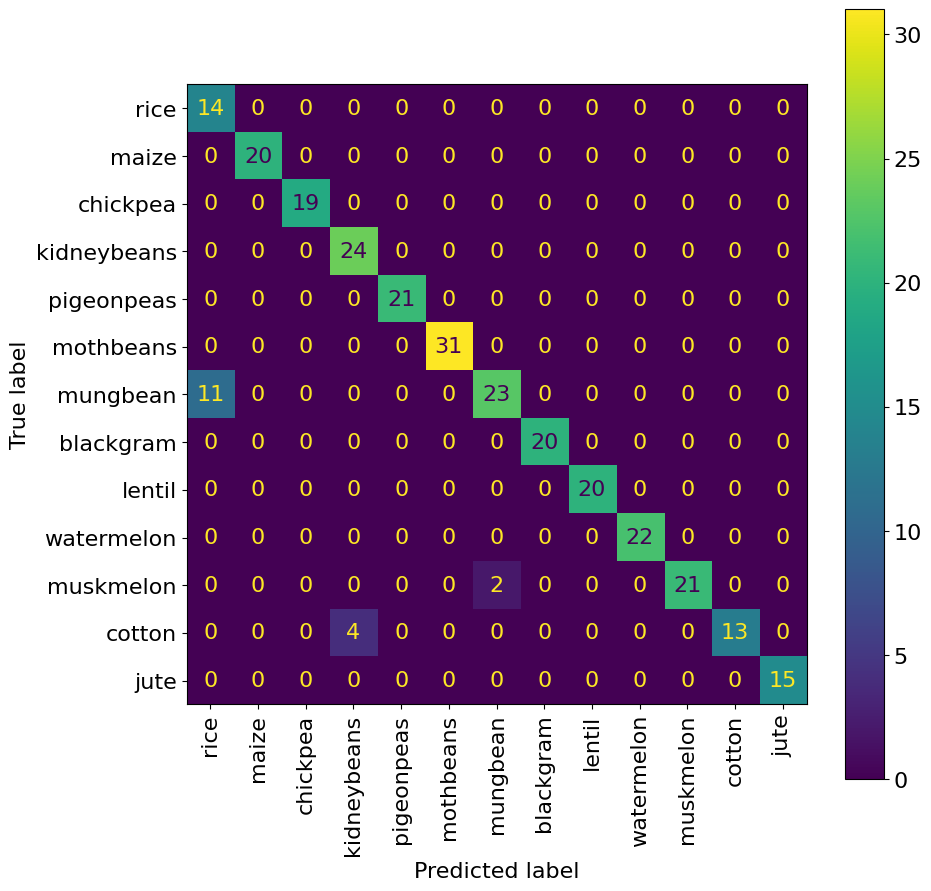

In [34]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = ['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'watermelon',
       'muskmelon', 'cotton', 'jute']

cm = confusion_matrix(Ytest, predicted_values)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))

cmp.plot(ax=ax, xticks_rotation='vertical')

In [35]:
print("Metric Evaluation for Decision Tree ")

precision.append(round(precision_score(Ytest, predicted_values, average="macro"),4))
recall.append(round(recall_score(Ytest, predicted_values, average="macro"),4))
f1score.append(round(f1_score(Ytest, predicted_values, average="macro"),4))

print("Avg Precision: "+ str(round(precision_score(Ytest, predicted_values, average="macro"),4)))
print("Avg Recall: " + str(round(recall_score(Ytest, predicted_values, average="macro"),4)))
print("Avg F1 score: " + str(round(f1_score(Ytest, predicted_values, average="macro"),4)))

Metric Evaluation for Decision Tree 
Avg Precision: 0.949
Avg Recall: 0.9503
Avg F1 score: 0.9417


**SMOTE**

In [36]:
DecisionTree_smote = DecisionTreeClassifier(criterion="entropy",random_state=2,max_depth=5)

DecisionTree_smote.fit(X_train_sm, y_train_sm)

predicted_values = DecisionTree.predict(Xtest)
x = metrics.accuracy_score(Ytest, predicted_values)

print("DecisionTrees's Accuracy with SMOTE is: ", x*100)

print(classification_report(Ytest,predicted_values))

report11 = classification_report(Ytest,predicted_values)

DecisionTrees's Accuracy with SMOTE is:  93.92857142857143
              precision    recall  f1-score   support

   blackgram       0.56      1.00      0.72        14
    chickpea       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        19
        jute       0.86      1.00      0.92        24
 kidneybeans       1.00      1.00      1.00        21
      lentil       1.00      1.00      1.00        31
       maize       0.92      0.68      0.78        34
   mothbeans       1.00      1.00      1.00        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        22
  pigeonpeas       1.00      0.91      0.95        23
        rice       1.00      0.76      0.87        17
  watermelon       1.00      1.00      1.00        15

    accuracy                           0.94       280
   macro avg       0.95      0.95      0.94       280
weighted avg       0.96      0.94      0.94       280



In [37]:
from sklearn.model_selection import cross_val_score

In [38]:
# Cross validation score (Decision Tree)
score = cross_val_score(DecisionTree, features1, target1,cv=5)

In [39]:
score

array([0.93571429, 0.95      , 0.93928571, 0.93928571, 0.91428571])

In [40]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=20, random_state=0)
RF.fit(Xtrain,Ytrain)

predicted_values = RF.predict(Xtest)

x = metrics.accuracy_score(Ytest, predicted_values)
acc.append(x)
model.append('RF')
print("RF's Accuracy is: ", x)

print(classification_report(Ytest,predicted_values))

RF's Accuracy is:  0.9892857142857143
              precision    recall  f1-score   support

   blackgram       1.00      0.93      0.96        14
    chickpea       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        19
        jute       1.00      0.92      0.96        24
 kidneybeans       1.00      1.00      1.00        21
      lentil       1.00      1.00      1.00        31
       maize       0.97      1.00      0.99        34
   mothbeans       1.00      1.00      1.00        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        22
  pigeonpeas       1.00      1.00      1.00        23
        rice       0.89      1.00      0.94        17
  watermelon       1.00      1.00      1.00        15

    accuracy                           0.99       280
   macro avg       0.99      0.99      0.99       280
weighted avg       0.99      0.99      0.99       280



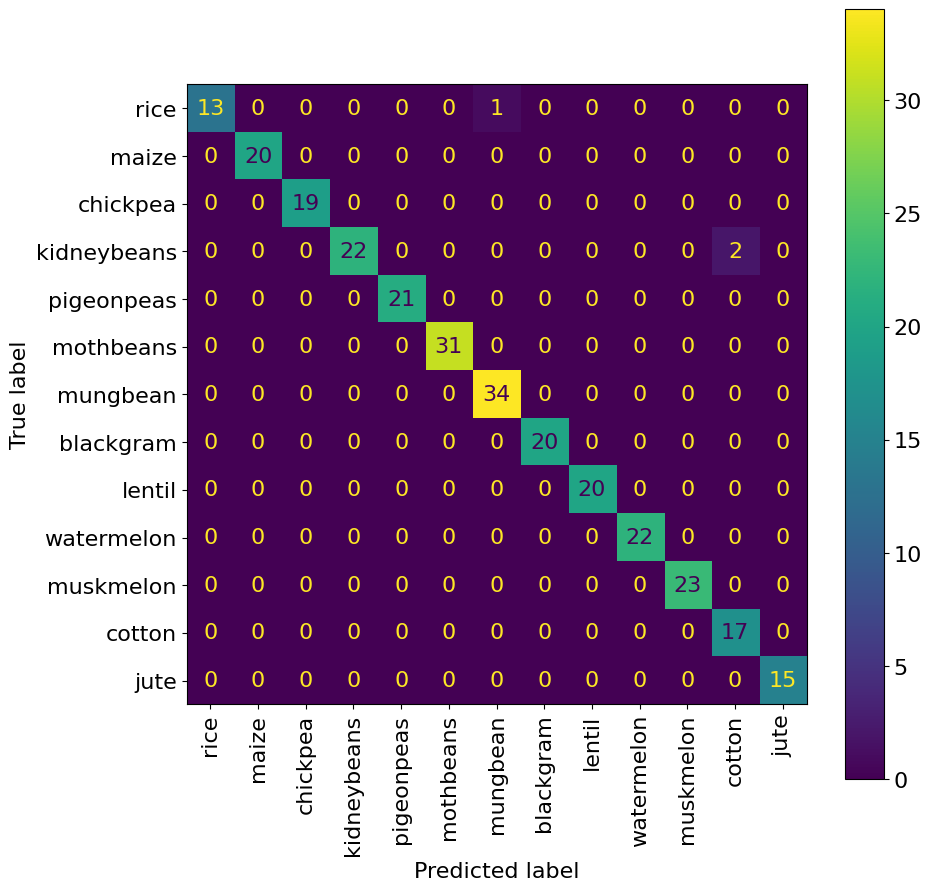

In [41]:
cm = confusion_matrix(Ytest, predicted_values)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
plt.rcParams.update({'font.size': 16})
cmp.plot(ax=ax, xticks_rotation='vertical')

In [42]:
# Cross validation score (Random Forest)
score = cross_val_score(RF,features1,target1,cv=5)
score

array([0.98928571, 0.98928571, 0.99285714, 0.99285714, 0.975     ])

In [43]:
print("Metric Evaluation for Random Forest ")

precision.append(round(precision_score(Ytest, predicted_values, average="macro"),4))
recall.append(round(recall_score(Ytest, predicted_values, average="macro"),4))
f1score.append(round(f1_score(Ytest, predicted_values, average="macro"),4))
print("Avg Precision: "+ str(round(precision_score(Ytest, predicted_values, average="macro"),4)))
print("Avg Recall: " + str(round(recall_score(Ytest, predicted_values, average="macro"),4)))
print("Avg F1 score: " + str(round(f1_score(Ytest, predicted_values, average="macro"),4)))

Metric Evaluation for Random Forest 
Avg Precision: 0.9897
Avg Recall: 0.9881
Avg F1 score: 0.9884


In [44]:
RF_smote = RandomForestClassifier(n_estimators=20, random_state=0)
RF_smote.fit(X_train_sm, y_train_sm )

predicted_values = RF.predict(Xtest)

x = metrics.accuracy_score(Ytest, predicted_values)

print("RF's Accuracy using SMOTE is: ", x)

print(classification_report(Ytest,predicted_values))

RF's Accuracy using SMOTE is:  0.9892857142857143
              precision    recall  f1-score   support

   blackgram       1.00      0.93      0.96        14
    chickpea       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        19
        jute       1.00      0.92      0.96        24
 kidneybeans       1.00      1.00      1.00        21
      lentil       1.00      1.00      1.00        31
       maize       0.97      1.00      0.99        34
   mothbeans       1.00      1.00      1.00        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        22
  pigeonpeas       1.00      1.00      1.00        23
        rice       0.89      1.00      0.94        17
  watermelon       1.00      1.00      1.00        15

    accuracy                           0.99       280
   macro avg       0.99      0.99      0.99       280
weighted avg       0.99      0.99      0.99       280



In [45]:
from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression(random_state=2)

LogReg.fit(Xtrain,Ytrain)

predicted_values = LogReg.predict(Xtest)

x = metrics.accuracy_score(Ytest, predicted_values)
acc.append(x)
model.append('Logistic Regression')
print("Logistic Regression's Accuracy is: ", x)

print(classification_report(Ytest,predicted_values))

Logistic Regression's Accuracy is:  0.8535714285714285
              precision    recall  f1-score   support

   blackgram       0.61      0.79      0.69        14
    chickpea       0.95      1.00      0.98        20
      cotton       0.64      0.74      0.68        19
        jute       0.87      0.83      0.85        24
 kidneybeans       0.95      0.95      0.95        21
      lentil       0.89      0.77      0.83        31
       maize       0.73      0.71      0.72        34
   mothbeans       1.00      0.75      0.86        20
    mungbean       0.95      1.00      0.98        20
   muskmelon       1.00      1.00      1.00        22
  pigeonpeas       0.90      0.78      0.84        23
        rice       0.76      0.94      0.84        17
  watermelon       0.94      1.00      0.97        15

    accuracy                           0.85       280
   macro avg       0.86      0.87      0.86       280
weighted avg       0.86      0.85      0.85       280



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


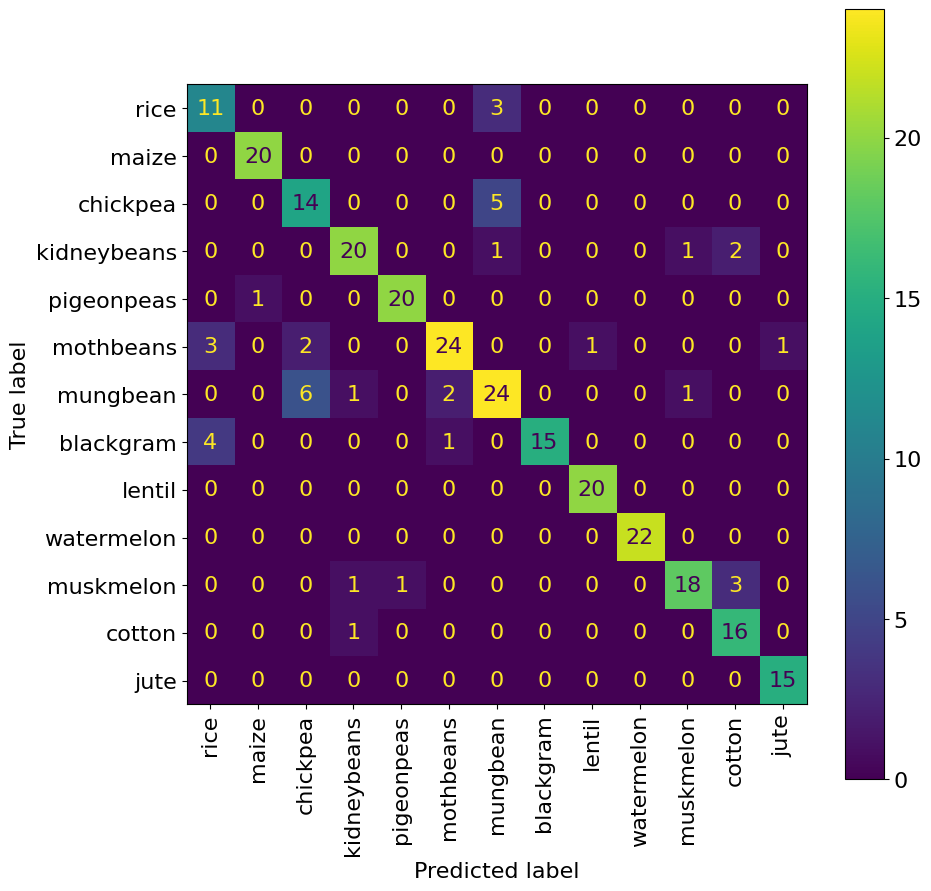

In [46]:
cm = confusion_matrix(Ytest, predicted_values)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
plt.rcParams.update({'font.size': 16})
cmp.plot(ax=ax, xticks_rotation='vertical')

In [47]:
# Cross validation score (Logistic Regression)
score = cross_val_score(LogReg,features1,target1,cv=5)
score

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

array([0.88928571, 0.86071429, 0.85357143, 0.85714286, 0.86785714])

In [48]:
print("Metric Evaluation for Logistic Regression ")

precision.append(round(precision_score(Ytest, predicted_values, average="macro"),4))
recall.append(round(recall_score(Ytest, predicted_values, average="macro"),4))
f1score.append(round(f1_score(Ytest, predicted_values, average="macro"),4))

print("Avg Precision: "+ str(round(precision_score(Ytest, predicted_values, average="macro"),4)))
print("Avg Recall: " + str(round(recall_score(Ytest, predicted_values, average="macro"),4)))
print("Avg F1 score: " + str(round(f1_score(Ytest, predicted_values, average="macro"),4)))

Metric Evaluation for Logistic Regression 
Avg Precision: 0.8607
Avg Recall: 0.8663
Avg F1 score: 0.8595


In [49]:
from sklearn.linear_model import LogisticRegression

LogReg_smote = LogisticRegression(random_state=2)

LogReg.fit(X_train_sm, y_train_sm)

predicted_values = LogReg.predict(Xtest)

x = metrics.accuracy_score(Ytest, predicted_values)

print("Logistic Regression's Accuracy using SMOTE is: ", x)
print(classification_report(Ytest,predicted_values))

Logistic Regression's Accuracy using SMOTE is:  0.8285714285714286
              precision    recall  f1-score   support

   blackgram       0.67      0.86      0.75        14
    chickpea       0.83      1.00      0.91        20
      cotton       0.59      0.89      0.71        19
        jute       0.75      0.75      0.75        24
 kidneybeans       1.00      0.86      0.92        21
      lentil       0.83      0.77      0.80        31
       maize       0.79      0.56      0.66        34
   mothbeans       1.00      0.75      0.86        20
    mungbean       0.90      0.90      0.90        20
   muskmelon       1.00      1.00      1.00        22
  pigeonpeas       0.95      0.83      0.88        23
        rice       0.71      0.88      0.79        17
  watermelon       0.94      1.00      0.97        15

    accuracy                           0.83       280
   macro avg       0.84      0.85      0.84       280
weighted avg       0.85      0.83      0.83       280



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [50]:
from sklearn.svm import SVC
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler
# fit scaler on training data
norm = MinMaxScaler().fit(Xtrain)
X_train_norm = norm.transform(Xtrain)
# transform testing dataabs
X_test_norm = norm.transform(Xtest)
SVM = SVC(kernel='poly', degree=3, C=1)
SVM.fit(X_train_norm,Ytrain)
predicted_values = SVM.predict(X_test_norm)
x = metrics.accuracy_score(Ytest, predicted_values)
acc.append(x)
model.append('SVM')
print("SVM's Accuracy is: ", x)

print(classification_report(Ytest,predicted_values))

SVM's Accuracy is:  0.9678571428571429
              precision    recall  f1-score   support

   blackgram       1.00      0.86      0.92        14
    chickpea       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        19
        jute       0.88      0.92      0.90        24
 kidneybeans       1.00      1.00      1.00        21
      lentil       0.97      0.97      0.97        31
       maize       0.92      0.97      0.94        34
   mothbeans       1.00      1.00      1.00        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        22
  pigeonpeas       1.00      0.96      0.98        23
        rice       0.88      0.88      0.88        17
  watermelon       1.00      1.00      1.00        15

    accuracy                           0.97       280
   macro avg       0.97      0.97      0.97       280
weighted avg       0.97      0.97      0.97       280



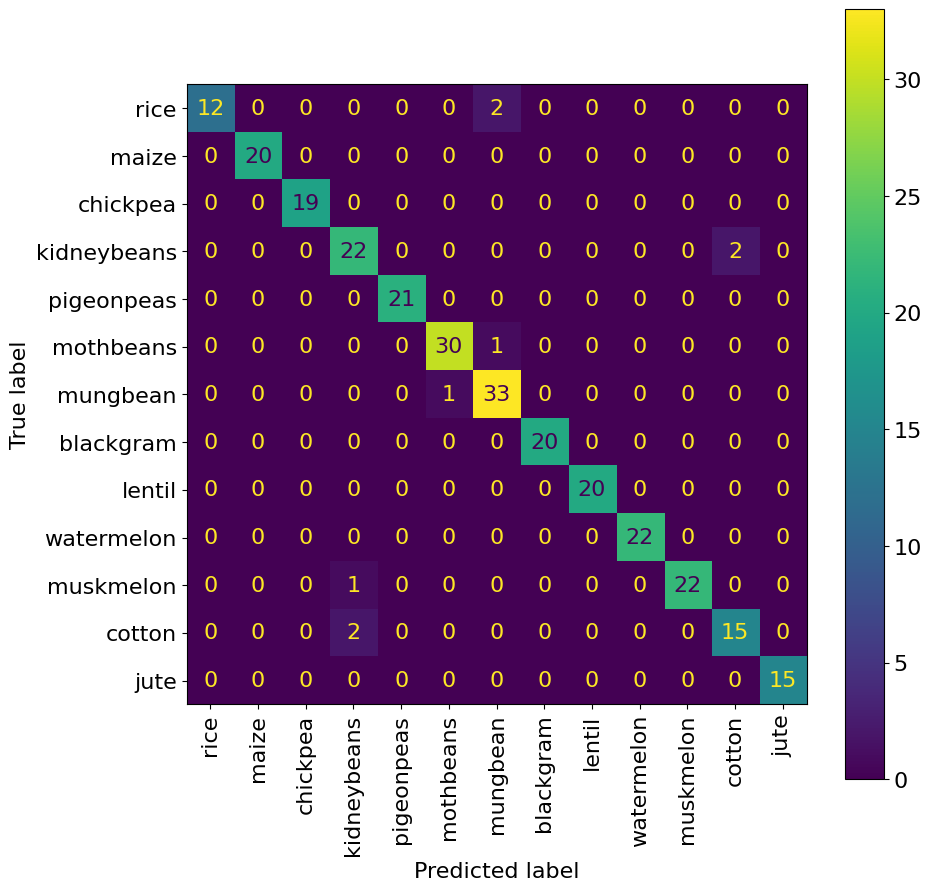

In [51]:
cm = confusion_matrix(Ytest, predicted_values)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
plt.rcParams.update({'font.size': 16})
cmp.plot(ax=ax, xticks_rotation='vertical')

In [52]:
# Cross validation score (SVM)
score = cross_val_score(SVM,features1,target1,cv=5)
score

array([0.86785714, 0.875     , 0.85714286, 0.875     , 0.86785714])

In [53]:
print("Metric Evaluation for SVM ")

precision.append(round(precision_score(Ytest, predicted_values, average="macro"),4))
recall.append(round(recall_score(Ytest, predicted_values, average="macro"),4))
f1score.append(round(f1_score(Ytest, predicted_values, average="macro"),4))

print("Avg Precision: "+ str(round(precision_score(Ytest, predicted_values, average="macro"),4)))
print("Avg Recall: " + str(round(recall_score(Ytest, predicted_values, average="macro"),4)))
print("Avg F1 score: " + str(round(f1_score(Ytest, predicted_values, average="macro"),4)))

Metric Evaluation for SVM 
Avg Precision: 0.9728
Avg Recall: 0.9655
Avg F1 score: 0.9686


In [54]:
norm1 = MinMaxScaler().fit(X_train_sm)
X_train_norm1 = norm1.transform(X_train_sm)

In [55]:
X_test_norm1 = norm1.transform(Xtest)
SVM = SVC(kernel='poly', degree=3, C=1)
SVM.fit(X_train_norm1,y_train_sm)
predicted_values = SVM.predict(X_test_norm)
x = metrics.accuracy_score(Ytest, predicted_values)

print("SVM's Accuracy using SMOTE is: ", x)

print(classification_report(Ytest,predicted_values))

SVM's Accuracy using SMOTE is:  0.9714285714285714
              precision    recall  f1-score   support

   blackgram       1.00      0.86      0.92        14
    chickpea       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        19
        jute       0.88      0.92      0.90        24
 kidneybeans       1.00      1.00      1.00        21
      lentil       0.97      1.00      0.98        31
       maize       0.94      0.97      0.96        34
   mothbeans       1.00      1.00      1.00        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        22
  pigeonpeas       1.00      0.96      0.98        23
        rice       0.88      0.88      0.88        17
  watermelon       1.00      1.00      1.00        15

    accuracy                           0.97       280
   macro avg       0.97      0.97      0.97       280
weighted avg       0.97      0.97      0.97       280



In [56]:
def show_values(axs, orient="v", space=.00000001):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.4f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center")
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.3f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

In [57]:
from sklearn.neighbors import KNeighborsClassifier
k=5
knn = KNeighborsClassifier(n_neighbors = k)
knn.fit(Xtrain,Ytrain)
x = metrics.accuracy_score(Ytest, predicted_values)
acc.append(x)
model.append('knn')
print("KNN's Accuracy is: ", x)

print(classification_report(Ytest,predicted_values))


KNN's Accuracy is:  0.9714285714285714
              precision    recall  f1-score   support

   blackgram       1.00      0.86      0.92        14
    chickpea       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        19
        jute       0.88      0.92      0.90        24
 kidneybeans       1.00      1.00      1.00        21
      lentil       0.97      1.00      0.98        31
       maize       0.94      0.97      0.96        34
   mothbeans       1.00      1.00      1.00        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        22
  pigeonpeas       1.00      0.96      0.98        23
        rice       0.88      0.88      0.88        17
  watermelon       1.00      1.00      1.00        15

    accuracy                           0.97       280
   macro avg       0.97      0.97      0.97       280
weighted avg       0.97      0.97      0.97       280



In [58]:
# Metric evaluation for KNN
precision.append(round(precision_score(Ytest, predicted_values, average="macro"), 4))
recall.append(round(recall_score(Ytest, predicted_values, average="macro"), 4))
f1score.append(round(f1_score(Ytest, predicted_values, average="macro"), 4))

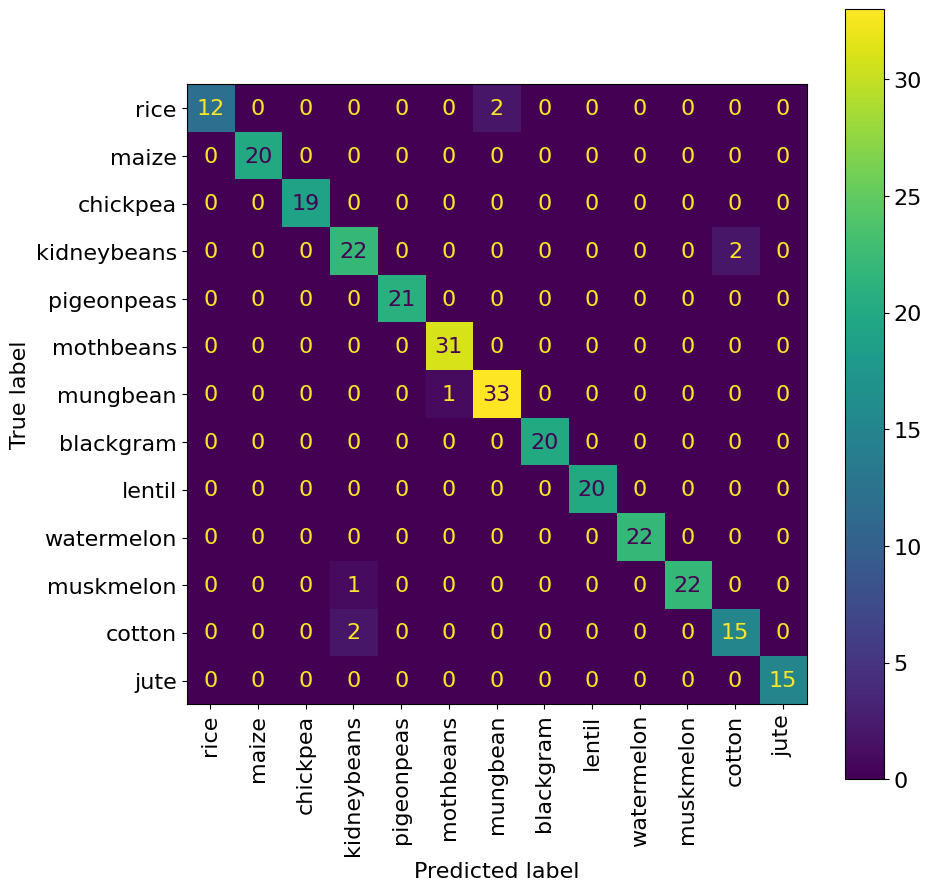

In [59]:
cm = confusion_matrix(Ytest, predicted_values)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
plt.rcParams.update({'font.size': 16})
cmp.plot(ax=ax, xticks_rotation='vertical')

In [60]:
from sklearn.neighbors import KNeighborsClassifier
k=5
knn_smote = KNeighborsClassifier(n_neighbors = k)
knn_smote.fit(X_train_sm, y_train_sm)
x_smote = metrics.accuracy_score(Ytest, predicted_values)

print("KNN's Smote Accuracy is: ", x_smote)

print(classification_report(Ytest,predicted_values))

KNN's Smote Accuracy is:  0.9714285714285714
              precision    recall  f1-score   support

   blackgram       1.00      0.86      0.92        14
    chickpea       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        19
        jute       0.88      0.92      0.90        24
 kidneybeans       1.00      1.00      1.00        21
      lentil       0.97      1.00      0.98        31
       maize       0.94      0.97      0.96        34
   mothbeans       1.00      1.00      1.00        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        22
  pigeonpeas       1.00      0.96      0.98        23
        rice       0.88      0.88      0.88        17
  watermelon       1.00      1.00      1.00        15

    accuracy                           0.97       280
   macro avg       0.97      0.97      0.97       280
weighted avg       0.97      0.97      0.97       280



<ipython-input-61-9949cddbb5ce>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  p = sns.barplot(x = model,y = acc, ci=None)


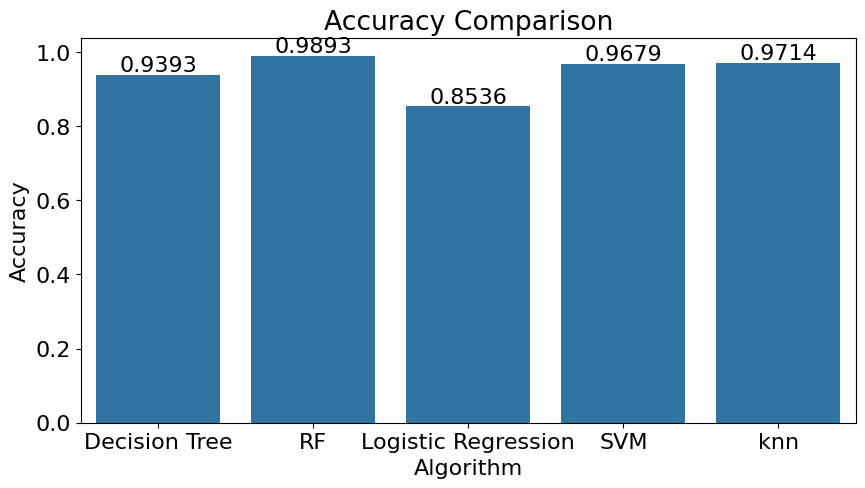

In [61]:
plt.figure(figsize=[10,5],dpi = 100)
plt.title('Accuracy Comparison')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
p = sns.barplot(x = model,y = acc, ci=None)
show_values(p)

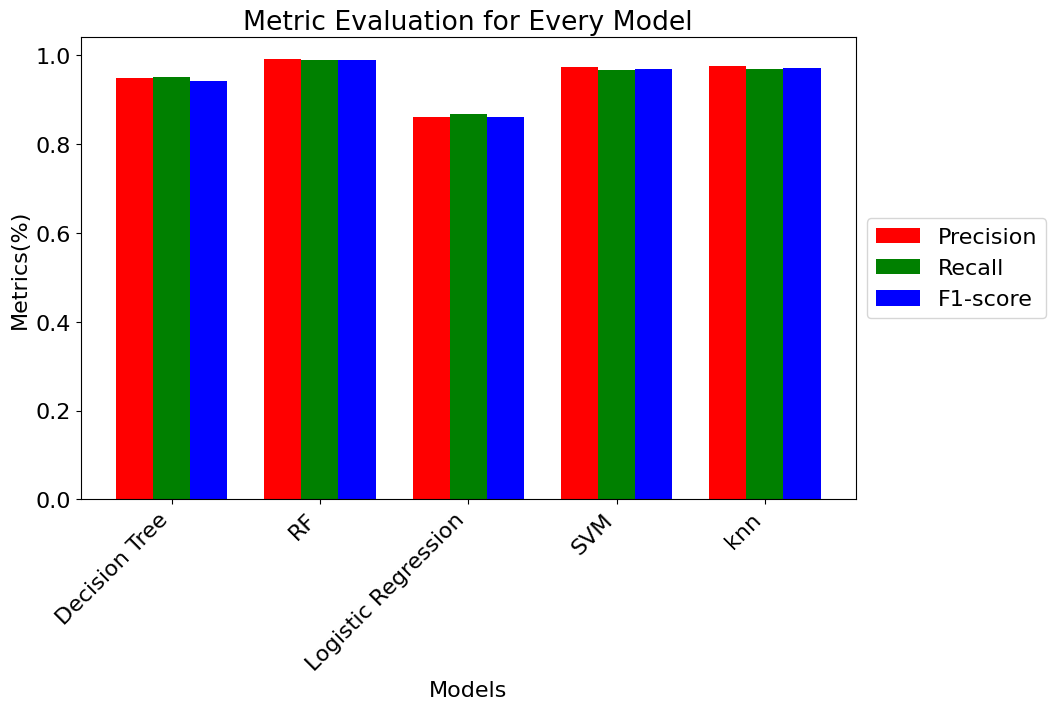

In [62]:
import numpy as np
import matplotlib.pyplot as plt

N = len(model)
ind = np.arange(N)
width = 0.25

fig, ax = plt.subplots()
bar1 = ax.bar(ind, precision, width, color='r', label='Precision')
bar2 = ax.bar(ind + width, recall, width, color='g', label='Recall')
bar3 = ax.bar(ind + 2*width, f1score, width, color='b', label='F1-score')

ax.set_xlabel("Models")
ax.set_ylabel('Metrics(%)')
ax.set_title("Metric Evaluation for Every Model")
ax.set_xticks(ind + width)
ax.set_xticklabels(model, rotation=45, horizontalalignment='right')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.set_size_inches(10, 6)

plt.show()

In [63]:
@anvil.server.callable
def predict_crop(temperature,humidity,ph,water_availability,season):
  # Log input values
  print(f"Temperature: {temperature}, Humidity: {humidity}, PH: {ph}, Water Availability: {water_availability}, Season: {season}")

  try:
    temperature = float(temperature)
    humidity = float(humidity)
    ph = float(ph)
    water_availability = float(water_availability)
  except ValueError:
    return "Invalid input. Please enter numeric values."
  # Handle the 'Season' value separately
  # if not season.isdigit():
  #   return "Invalid input. Please enter a numeric value for 'Season'."
  # Convert 'Season' to integer
  season = int(season)

  classification = RF.predict([[temperature,humidity,ph,water_availability,season]])

  return classification


In [ ]:
anvil.server.wait_forever()